# FRAUD CLASSIFICATION FROM CUSTOMER / TRANSACTION DATA
**Objective** is to build a model to predict fraudulent customers on the basis of information about the transactions they use to make and the purchases they've done.<br><br>one json file is provided with multiple data type : customer's , transactions, orders and payements.

**Contents:**
1. [** customer table exploration**](#s1)
2. [** Other tables exploration**](#s2)
3. [** Modeling **](#s3)

In [556]:
## imports
import pandas as pd
import os 
import json
import re   
import requests
import numpy as np

import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans, KMeans , DBSCAN
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from itertools import product
%matplotlib inline
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split , GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression , RidgeClassifier
from sklearn import tree , linear_model , svm
from sklearn.metrics import accuracy_score
np.random.seed(7)

import warnings
warnings.filterwarnings("ignore")


In [572]:
## fuctions
def get_flag(x):
    assert type(x) == int
    return 1 if x >= 1 else 0
def get_dummies_flag(x,agg = 'sum'):
    return get_flag(sum(x))

from sklearn.metrics import confusion_matrix, precision_recall_curve , auc, average_precision_score,roc_auc_score,roc_curve,average_precision_score,accuracy_score, precision_score, recall_score
def graphe_contingence(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlGn):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.xlim([-1, 2])
    plt.ylim([-1, 2])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# print tableau et scores
def scors_aff(t_test , t_predict):
    try : 
        print("Accuracy is {0:.2f}".format(accuracy_score(t_test, t_predict)))
        print("Precision is {0:.2f}".format(precision_score(t_test, t_predict)))
        print("Recall is {0:.2f}".format(recall_score(t_test, t_predict)))
        print("AUC is {0:.2f}".format(roc_auc_score(t_test, t_predict)))
    except :
        1
    recall_acc = confusion_matrix(t_test,t_predict)
    graphe_contingence(recall_acc
                      , classes=[ 'No_fraud','fraud']
                      , title='Confusion matrix')
    plt.show()

# metric function
def recall_curv(y_test , y_score):
    mmap = [ 'fraud','No_fraud']
    precision, recall , PR_thresholds = precision_recall_curve(y_test,y_score)
    PR_area = auc(recall, precision)
    average_precision = average_precision_score(y_test, y_score)
    
    #avec les données en entiers
    precision_micro, recall_micro, _ = precision_recall_curve(y_test, y_score)
    average_precision_micro = average_precision_score(y_test, y_score, average='micro')
    # Plot Precision-Recall curve for each class
    plt.clf()
    plt.plot(recall_micro, precision_micro, label='micro-average Precision-recall curve (PR_area = {0:0.2f})'.format(average_precision_micro))


    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(' Precision-Recall curve ')
    plt.legend(loc="lower right")
    plt.show

In [383]:
#open json 
with open('user_profiles.json', encoding="utf8") as f:
    data = f.readlines()
    data = [json.loads(line) for line in data] #convert string to dict format
    
# load data into different tables 
df_pay =pd.json_normalize(data,'paymentMethods',[['customer','customerEmail']],errors='ignore')
df_orders = pd.json_normalize(data,'orders',[['customer','customerEmail']],errors='ignore')
df_trans = pd.json_normalize(data,'transactions',[['customer','customerEmail']],errors='ignore')
df_cust = pd.json_normalize(data).drop(columns = ['orders','paymentMethods','transactions'])
fraud = df_cust[['fraudulent']]

### Get table for each field : 
        -Orders
        -Paiements
        -Transactions
        -Customers

fraudulent    0.363095
dtype: float64


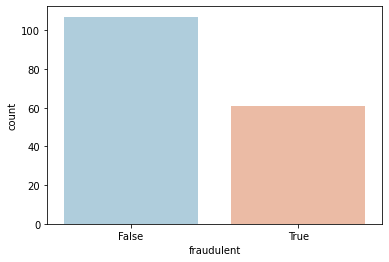

In [415]:
# events to predict 
import seaborn as sns
sns.countplot(x='fraudulent',data=fraud,palette='RdBu_r')
print(fraud.mean())

### we're not on a unbalanced data situation ==> no balacing technic to be made

In [168]:
df_cust.nunique()

fraudulent                           2
customer.customerEmail             161
customer.customerPhone             168
customer.customerDevice            168
customer.customerIPAddress         165
customer.customerBillingAddress    166
dtype: int64


# ** customer table exploration** <a id='s1'></a>
1. check duplicates mails ==> decides if its suits for an customers id 
2. create features for customers table 
3. get insights from customersmail
4. going further : get insights from addresses and ip.addresses

In [169]:
df_cust[df_cust.duplicated(subset=['customer.customerEmail'],keep=False)]

,fraudulent,customer.customerEmail,customer.customerPhone,customer.customerDevice,customer.customerIPAddress,customer.customerBillingAddress
7,True,johnlowery@gmail.com,044-642-9860,rjb0adai34izqvys4938,212.144.68.190,"484 Pamela Pass\nLake Jessicaview, WI 12942-9074"
40,True,johnlowery@gmail.com,737-377-9701x577,jz66ap43id2y35ivfqa5,6c21:ac1d:2089:68fa:abb7:8c00:525f:6588,"08238 Kyle Squares Suite 893\nMillermouth, IN ..."
45,True,johnlowery@gmail.com,+16(4)9016414340,cdx178qymd6vy77nm4x3,222.79.159.140,"77711 Pamela Ridge\nNew Kayla, IL 27182"
65,True,johnlowery@gmail.com,04712252182,311kdz4c1210iixltk2j,42b3:df19:86fe:abd9:dafe:f6c1:eb76:c72,"11704 Andrew Villages Apt. 035\nJamesfurt, OR ..."
79,True,johnlowery@gmail.com,1-820-539-4726x993,2in0fh7lep289n8dcbdz,163.128.139.42,"814 Wagner Union\nAshleymouth, HI 35617"
133,True,johnlowery@gmail.com,1-143-059-1833,tyijaify2hqadwslejyr,e4c:fb48:8ee2:9819:6ae8:8d3f:3b6a:a788,"518 Wood Mews Apt. 970\nDillonstad, NE 43317-3945"
155,True,johnlowery@gmail.com,076-099-0630x72770,6qy6oa3nqutsyyxzc54c,f259:657f:f329:2fca:c06c:8b57:d6ac:2380,"687 Rogers Bridge Suite 780\nValdezburgh, IN 2..."
165,True,johnlowery@gmail.com,635.676.0955x524,969zz9zdj8z4gns4sx5p,f82c:811f:8a02:e2d6:79b:fcaa:42de:570b,"548 Bryant Inlet\nVeronicaside, OK 00522"


### using different phone-number, devices , addresses and Ip-Add can be a way of detecting fraudulent transaction
### keeping customer's mail as an id but keep trace of the nb of other featurers

In [523]:
# get clients aggregated features 
temp_table = df_cust.groupby(['customer.customerEmail']).nunique().reset_index().drop(columns=['fraudulent'])
temp_table.columns = ['customer.customerEmail','nb_phones','nb_device','nb_address','nb_billingadd']
df_cust = df_cust.merge(temp_table,
                       right_on =  'customer.customerEmail',
                       left_on = 'customer.customerEmail',
                       how = 'inner')

### mail domains
df_cust['mail_domaine'] = df_cust['customer.customerEmail'].apply(lambda x: x.split('@')[1])

## valid mails 
regex = '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$'
df_cust['real_mail'] = df_cust['customer.customerEmail'].apply(lambda x: int(bool(re.fullmatch(regex,x))))

### flags
df_cust['flag_phones'] = df_cust['nb_phones'].apply(lambda x:get_flag(x))
df_cust['flag_devices'] = df_cust['nb_device'].apply(lambda x:get_flag(x))
df_cust['flag_addres'] = df_cust['nb_address'].apply(lambda x:get_flag(x))
df_cust['flag_billingadd'] = df_cust['nb_billingadd'].apply(lambda x:get_flag(x))


In [235]:
## check mail_domaine 
check_domaine = df_cust[["mail_domaine","fraudulent","customer.customerEmail"]].groupby(["mail_domaine","fraudulent"])\
            .agg('count').unstack()
check_domaine['tot']=check_domaine.sum(axis = 1) 
check_domaine.nlargest(10,('customer.customerEmail',True))

customer.customerEmail         tot
fraudulent                        False  True      
mail_domaine                                       
gmail.com                          16.0  15.0  31.0
hotmail.com                        17.0   6.0  23.0
yahoo.com                          23.0   6.0  29.0
1jcfcxs7                            NaN   1.0   1.0
6eph                                NaN   1.0   1.0
arnold.com                          NaN   1.0   1.0
brewer-jones.com                    NaN   1.0   1.0
brown.com                           NaN   1.0   1.0
dunn.com                            NaN   1.0   1.0
gibson.com                          NaN   1.0   1.0

#### since any modalities are presented , we're keep the top three and group the rest of the domains

In [525]:
df_cust['mail_domaine'] = df_cust['mail_domaine'].apply(lambda x:x if x in ['gmail.com','hotmail.com','yahoo.com'] else 'autre')

<AxesSubplot:xlabel='real_mail', ylabel='count'>

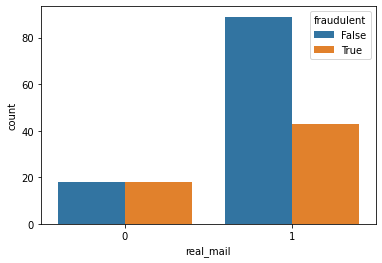

In [214]:
## valid mails 
sns.countplot(x='real_mail',hue='fraudulent',data=df_cust)

### 50% of non vaid mails are fraudulent ==> feature to be kept 

In [526]:
## make dummies for cust variables
domain_dumm  = pd.get_dummies(df_cust['mail_domaine'],drop_first=True)
df_cust =  pd.concat([df_cust,domain_dumm],axis=1)

## getting further 

#### get localisation from address and make clusters using googlemaps API such as : 
    -resident or foreign
    -country or city ...

#### get country from adress ip 



# ** Other tables exploration** <a id='s2'></a>
1. check if transactions and orders match==> join before doing the exploration 
2. Check if paument Ids matches between transactions and payments 
3. get insights from customersmail
4. going further : get insights from addresses and ip.addresses

In [367]:
## get amounts for each customers transaction
df_trans_noduporder = df_trans[['customer.customerEmail','orderId','transactionAmount']].drop_duplicates().reset_index().copy()
df_trans_noduporder['combined'] = df_trans_noduporder\
            .groupby(['customer.customerEmail']).transform(lambda x:dict(x))['transactionAmount']
df_trans_noduporder['combined']  = df_trans_noduporder['combined'].apply(lambda x:str(x))
dftrans = df_trans_noduporder[['customer.customerEmail','combined']].drop_duplicates()

## get amounts for each customers order
df_orders['combined'] = df_orders[['customer.customerEmail','orderAmount']]\
           .groupby(['customer.customerEmail']).transform(lambda x:dict(x))
df_orders['combined']  = df_orders['combined'].apply(lambda x:str(x))
dforders = df_orders[['customer.customerEmail','combined']].drop_duplicates().set_index('customer.customerEmail')

compare = dftrans.join(dforders,how = 'outer',on = 'customer.customerEmail', 
                      lsuffix='_tr', rsuffix='_or')

In [374]:
compare['flag_match'] = compare.combined_tr == compare.combined_or
print('how many matches :',compare['flag_match'].count())
compare

how many matches : 136


,customer.customerEmail,combined_tr,combined_or,flag_match
0,josephhoward@yahoo.com,"{0: 18, 1: 26}","{0: 18, 1: 26}",True
2,evansjeffery@yahoo.com,"{2: 45, 3: 23, 4: 43}","{2: 45, 3: 23, 4: 43}",True
5,andersonwilliam@yahoo.com,"{5: 33, 6: 24, 7: 25}","{5: 33, 6: 24, 7: 25}",True
8,rubenjuarez@yahoo.com,"{8: 34, 9: 26, 10: 25}","{8: 34, 9: 26, 10: 25}",True
11,uchen@malone.com,"{11: 71, 12: 66, 13: 69, 14: 46, 15: 68, 16: 5...","{11: 71, 12: 66, 13: 69, 14: 46, 15: 68, 16: 5...",True
...,...,...,...,...
453,patrickcalderon@russo.net,"{453: 16, 454: 47}","{453: 16, 454: 47}",True
455,mitchellvickie@brewer-jones.com,"{455: 31, 456: 61, 457: 34}","{455: 31, 456: 61, 457: 34}",True
458,sbrown@hughes.biz,"{458: 30, 459: 43, 460: 14, 461: 21, 462: 27}","{458: 30, 459: 43, 460: 14, 461: 21, 462: 27}",True
467,ethompson@jackson-sanders.com,"{467: 49, 468: 54, 469: 37, 470: 43, 471: 64, ...","{467: 49, 468: 54, 469: 37, 470: 43, 471: 64, ...",True


### we have the same number of orders

In [386]:
df_trans.columns,df_orders.columns

(Index(['transactionId', 'orderId', 'paymentMethodId', 'transactionAmount',
        'transactionFailed', 'customer.customerEmail'],
       dtype='object'),
 Index(['orderId', 'orderAmount', 'orderState', 'orderShippingAddress',
        'customer.customerEmail'],
       dtype='object'))

In [394]:
df_trans.nunique(),df_orders.nunique()

(transactionId             623
 orderId                   478
 paymentMethodId           237
 transactionAmount          67
 transactionFailed           2
 customer.customerEmail    136
 dtype: int64,
 orderId                   478
 orderAmount                67
 orderState                  3
 orderShippingAddress      274
 customer.customerEmail    136
 dtype: int64)

In [390]:
# join transactions and orders
df_tr_or = df_trans.join(df_orders.set_index('orderId'), how='outer',
                        on = 'orderId',rsuffix = '_or')
print(df_tr_or.orderId.nunique(),'unique Id ==> full join')
df_tr_or.head()

478 unique Id ==> full join


,transactionId,orderId,paymentMethodId,transactionAmount,transactionFailed,customer.customerEmail,orderAmount,orderState,orderShippingAddress,customer.customerEmail_or
0,a9lcj51r,vjbdvd,wt07xm68b,18,False,josephhoward@yahoo.com,18,pending,"5493 Jones Islands\nBrownside, CA 51896",josephhoward@yahoo.com
1,y4wcv03i,yp6x27,wt07xm68b,26,False,josephhoward@yahoo.com,26,fulfilled,"5493 Jones Islands\nBrownside, CA 51896",josephhoward@yahoo.com
2,5mi94sfw,nlghpa,41ug157xz,45,False,evansjeffery@yahoo.com,45,fulfilled,"898 Henry Ports\nNew Keithview, CA 95893-2497",evansjeffery@yahoo.com
3,br8ba1nu,uw0eeb,41ug157xz,23,False,evansjeffery@yahoo.com,23,fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,evansjeffery@yahoo.com
4,a33145ss,bn44oh,y3xp697jx,43,True,evansjeffery@yahoo.com,43,fulfilled,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",evansjeffery@yahoo.com


In [395]:
# check paymentId in both tables
df_tr_or.nunique(),df_pay.nunique()

(transactionId                623
 orderId                      478
 paymentMethodId              237
 transactionAmount             67
 transactionFailed              2
 customer.customerEmail       136
 orderAmount                   67
 orderState                     3
 orderShippingAddress         274
 customer.customerEmail_or    136
 dtype: int64,
 paymentMethodId                     342
 paymentMethodRegistrationFailure      2
 paymentMethodType                     4
 paymentMethodProvider                10
 paymentMethodIssuer                  20
 customer.customerEmail              150
 dtype: int64)

In [400]:
# join payments with orders and transaction
df_ope = df_pay.join(df_tr_or.set_index('paymentMethodId'), how='outer',
                        on = 'paymentMethodId',lsuffix = '_pay')
df_ope

,paymentMethodId,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer,customer.customerEmail_pay,transactionId,orderId,transactionAmount,transactionFailed,customer.customerEmail,orderAmount,orderState,orderShippingAddress,customer.customerEmail_or
0,wt07xm68b,True,card,JCB 16 digit,Citizens First Banks,josephhoward@yahoo.com,a9lcj51r,vjbdvd,18.0,False,josephhoward@yahoo.com,18.0,pending,"5493 Jones Islands\nBrownside, CA 51896",josephhoward@yahoo.com
0,wt07xm68b,True,card,JCB 16 digit,Citizens First Banks,josephhoward@yahoo.com,y4wcv03i,yp6x27,26.0,False,josephhoward@yahoo.com,26.0,fulfilled,"5493 Jones Islands\nBrownside, CA 51896",josephhoward@yahoo.com
1,y3xp697jx,True,bitcoin,VISA 16 digit,Solace Banks,evansjeffery@yahoo.com,a33145ss,bn44oh,43.0,True,evansjeffery@yahoo.com,43.0,fulfilled,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",evansjeffery@yahoo.com
2,6krszxc05,False,card,VISA 16 digit,Vertex Bancorp,evansjeffery@yahoo.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5z1szj2he,False,card,Diners Club / Carte Blanche,His Majesty Bank Corp.,evansjeffery@yahoo.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,3zmkegkb8,False,paypal,JCB 15 digit,Bastion Banks,dawn05@tucker-brown.com,xdw33hfp,p0gdbf,19.0,False,dawn05@tucker-brown.com,19.0,fulfilled,"130 Kimberly Junctions\nEricmouth, KS 59756-2919",dawn05@tucker-brown.com
340,7yen1m1q8,False,card,VISA 13 digit,Vertex Bancorp,dawn05@tucker-brown.com,wpd29k0c,ak5a9n,32.0,False,dawn05@tucker-brown.com,32.0,fulfilled,"750 Sarah Stream\nAndersonfurt, WI 68970",dawn05@tucker-brown.com
340,7yen1m1q8,False,card,VISA 13 digit,Vertex Bancorp,dawn05@tucker-brown.com,7yilsi1o,1bubxa,25.0,True,dawn05@tucker-brown.com,25.0,fulfilled,"130 Kimberly Junctions\nEricmouth, KS 59756-2919",dawn05@tucker-brown.com
340,7yen1m1q8,False,card,VISA 13 digit,Vertex Bancorp,dawn05@tucker-brown.com,c82k5bcv,1bubxa,25.0,False,dawn05@tucker-brown.com,25.0,fulfilled,"130 Kimberly Junctions\nEricmouth, KS 59756-2919",dawn05@tucker-brown.com


In [470]:
## check paymentMethodIssuer

df_ope.groupby(['paymentMethodIssuer']).count()['paymentMethodId']

paymentMethodIssuer
                             2
B                           13
Bastion Banks               67
Bulwark Trust Corp.         64
Citizens First Banks        60
Fountain Financial Inc.     72
Grand Credit Corporation    60
Her Majesty Trust           83
His Majesty Bank Corp.      74
Rose Bancshares             67
Solace Banks                50
Vertex Bancorp              78
a                            4
c                            9
e                            9
n                            2
o                            2
p                            1
r                            7
x                            4
Name: paymentMethodId, dtype: int64

In [471]:
## groupe low frequent Issuers
df_ope['paymentMethodIssuer'] = df_ope['paymentMethodIssuer'].apply(lambda x : x if x in ['Bastion Banks', 'Bulwark Trust Corp.', 'Citizens First Banks',
       'Fountain Financial Inc.', 'Grand Credit Corporation',
       'Her Majesty Trust', 'His Majesty Bank Corp.', 'Rose Bancshares',
       'Solace Banks', 'Vertex Bancorp'] else 'other')  

In [ ]:
## some cleaning 
df_ope.drop(columns =['customer.customerEmail_or','customer.customerEmail'],inplace = True)
df_ope.rename(columns={"customer.customerEmail_pay": "customer.customerEmail"},inplace = True)
df_ope.reset_index(inplace = True)
df_ope.drop(columns = ['index'], inplace = True)

In [503]:
## get aggregate features 

temp_table = df_ope.groupby(['customer.customerEmail']).nunique().reset_index()
temp_table.columns = ['customer.customerEmail', 'nb_paymentId',
       'paymentMethodRegistrationFailure', 'nb_pay_type',
       'nb_payProvider', 'nb_payIssuer', 'nb_trans',
       'nb_orders', 'transactionAmount', 'transactionFailed', 'orderAmount',
       'nb_orders_state', 'nb_shipping_add']
# compute nb of failed events
temp_table['nb_failed_pay'] = df_ope[df_ope['paymentMethodRegistrationFailure'] == False]\
                .groupby(['customer.customerEmail']).nunique().reset_index()['paymentMethodId']
temp_table['nb_failed_trans'] = df_ope[df_ope['transactionFailed'] == False]\
                .groupby(['customer.customerEmail']).nunique().reset_index()['transactionId']
temp_table['nb_failed_orders'] = df_ope[df_ope['orderState'] == 'failed']\
                .groupby(['customer.customerEmail']).nunique().reset_index()['orderId']
temp_table['nb_pending_orders'] = df_ope[df_ope['orderState'] == 'pending']\
                .groupby(['customer.customerEmail']).nunique().reset_index()['orderId']
# drop columns with the samen information 
temp_table.drop(columns = ['paymentMethodRegistrationFailure','transactionFailed','transactionAmount','orderAmount'])

,customer.customerEmail,nb_paymentId,nb_pay_type,nb_payProvider,nb_payIssuer,nb_trans,nb_orders,nb_orders_state,nb_shipping_add,nb_failed_pay,nb_failed_trans,nb_failed_orders,nb_pending_orders
0,1yf0@jedyz63t,4,2,4,3,10,5,1,3,4.0,5.0,1.0,1.0
1,3fooiar@6eph,1,1,1,1,0,0,0,0,1.0,1.0,3.0,1.0
2,9es7t@u6n7x,1,1,1,1,2,1,1,1,1.0,3.0,1.0,1.0
3,abigail08@yahoo.com,2,1,2,2,5,3,3,3,1.0,4.0,1.0,1.0
4,alec27@bell.com,2,1,2,2,6,4,2,1,2.0,3.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,whodges@yahoo.com,1,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN
146,xramos@hardy.net,1,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN
147,ybrown@gmail.com,3,1,3,2,5,4,2,1,NaN,NaN,NaN,NaN
148,ypruitt@hotmail.com,3,2,2,3,4,4,1,2,NaN,NaN,NaN,NaN


In [472]:
### check features of df_ope for dummies 
for col in ['paymentMethodType', 'paymentMethodProvider', 'paymentMethodIssuer',
       'customer.customerEmail', 'transactionId', 'orderId',
       'transactionAmount', 'transactionFailed', 'orderAmount', 'orderState',
       'orderShippingAddress'] :
    print(col,'==>',df_ope[col].nunique(),'\n')

paymentMethodType ==> 4 

paymentMethodProvider ==> 10 

paymentMethodIssuer ==> 11 

customer.customerEmail ==> 150 

transactionId ==> 623 

orderId ==> 478 

transactionAmount ==> 67 

transactionFailed ==> 2 

orderAmount ==> 67 

orderState ==> 3 

orderShippingAddress ==> 274 



#### we keep all the variables with less than 20 modality , excpet the faillure columns ( we already computed the fialed cols)


In [490]:
### get dummies and affect all useed modality to the customer
col_dummies = ['paymentMethodType', 'paymentMethodProvider', 'paymentMethodIssuer',
       'orderState']
dummies_list = []
for col in col_dummies:
    dummies_list.append(pd.get_dummies(df_ope[col],drop_first=True))
    #print(col,pd.get_dummies(df_ope[col],drop_first=True).columns)

## merge table dummies 
dmm = pd.concat(dummies_list,axis=1)

## merge with df_ope to get customeremail ( id to merge with with the temp_table)
dmm = dmm.merge(df_ope[['customer.customerEmail']] , left_index = True , right_index = True ,how = 'outer')

In [515]:
dmm.groupby(['customer.customerEmail']).sum().applymap(get_flag)

,bitcoin,card,paypal,Diners Club / Carte Blanche,Discover,JCB 15 digit,JCB 16 digit,Maestro,Mastercard,VISA 13 digit,...,Fountain Financial Inc.,Grand Credit Corporation,Her Majesty Trust,His Majesty Bank Corp.,Rose Bancshares,Solace Banks,Vertex Bancorp,other,fulfilled,pending
customer.customerEmail,,,,,,,,,,,,,,,,,,,,,
1yf0@jedyz63t,0,1,1,0,0,0,0,1,1,1,...,0,0,1,0,1,0,0,0,1,0
3fooiar@6eph,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
9es7t@u6n7x,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
abigail08@yahoo.com,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,1
alec27@bell.com,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
whodges@yahoo.com,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
xramos@hardy.net,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
ybrown@gmail.com,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [516]:
## aggregate dummies for customers
dmm_agg = dmm.groupby(['customer.customerEmail']).sum().applymap(get_flag)

# get all features from temp_tabme
features_ope = dmm_agg.join(temp_table.set_index('customer.customerEmail'),how = 'outer',
                           on= 'customer.customerEmail')
     

In [407]:
df_ope.info() , df_ope.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 728 entries, 0 to 341
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   paymentMethodId                   728 non-null    object 
 1   paymentMethodRegistrationFailure  728 non-null    bool   
 2   paymentMethodType                 728 non-null    object 
 3   paymentMethodProvider             728 non-null    object 
 4   paymentMethodIssuer               728 non-null    object 
 5   customer.customerEmail_pay        728 non-null    object 
 6   transactionId                     623 non-null    object 
 7   orderId                           623 non-null    object 
 8   transactionAmount                 623 non-null    float64
 9   transactionFailed                 623 non-null    object 
 10  customer.customerEmail            623 non-null    object 
 11  orderAmount                       623 non-null    float64
 12  orderSta

(None,
 paymentMethodId                     342
 paymentMethodRegistrationFailure      2
 paymentMethodType                     4
 paymentMethodProvider                10
 paymentMethodIssuer                  20
 customer.customerEmail_pay          150
 transactionId                       623
 orderId                             478
 transactionAmount                    67
 transactionFailed                     2
 customer.customerEmail              136
 orderAmount                          67
 orderState                            3
 orderShippingAddress                274
 customer.customerEmail_or           136
 dtype: int64)

### since the customeremail from payment tabe got more unique values and got no missing data ==> better for customerId to merge with customer table 


In [535]:
#merge with csutomer table 
df = df_cust.join(features_ope,how = 'outer',
                on = 'customer.customerEmail')

#### we  are going to drop some columns such as :
    - customerPhone
    - customerDevice
    - Ipaddress ...

In [536]:
df.drop(columns = ['customer.customerEmail', 'customer.customerPhone',
       'customer.customerDevice', 'customer.customerIPAddress',
       'customer.customerBillingAddress','mail_domaine', 'real_mail'
                  ] , inplace = True)

In [537]:
df.head()

,fraudulent,nb_phones,nb_device,nb_address,nb_billingadd,flag_phones,flag_devices,flag_addres,flag_billingadd,gmail.com,...,nb_orders,transactionAmount,transactionFailed,orderAmount,nb_orders_state,nb_shipping_add,nb_failed_pay,nb_failed_trans,nb_failed_orders,nb_pending_orders
0,False,1,1,1,1,1,1,1,1,0,...,2.0,2.0,1.0,2.0,2.0,1.0,1.0,5.0,NaN,NaN
1,True,1,1,1,1,1,1,1,1,0,...,3.0,3.0,2.0,3.0,1.0,3.0,1.0,1.0,NaN,NaN
2,False,1,1,1,1,1,1,1,1,0,...,3.0,3.0,2.0,3.0,2.0,2.0,4.0,4.0,1.0,1.0
3,False,1,1,1,1,1,1,1,1,0,...,3.0,3.0,1.0,3.0,1.0,2.0,1.0,2.0,NaN,NaN
4,True,1,1,1,1,1,1,1,1,0,...,7.0,7.0,2.0,7.0,2.0,2.0,10.0,4.0,NaN,NaN


## **Modeling**  <a id='s3'></a>


In [546]:

y = df['fraudulent']
X = df.drop([ 'fraudulent'], axis = 1)
print(np.mean(y))
X = X.fillna(0)

0.3630952380952381


In [547]:
### add some clustering to features before modelign 
kmeans = KMeans(init ='k-means++', n_clusters = 6).fit(X)
clusters = kmeans.labels_
X['clusters'] = clusters


C:\Users\m2409\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [548]:
# sclaing 

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [549]:
#" split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101,stratify=y)

In [551]:
## train pieplines


# Construct some pipelines
pipe_lr = Pipeline([('pca', PCA()),
('clf', LogisticRegression())])

pipe_svm = Pipeline([('pca', PCA()),
('clf', svm.SVC(random_state=42,probability=True))])

pipe_dt = Pipeline([('pca', PCA()),
('clf', tree.DecisionTreeClassifier())])

pipe_rf = Pipeline([('pca', PCA()),
			('clf', RandomForestClassifier())])

pipe_lasso = Pipeline([('pca', PCA()),
('clf', linear_model.RidgeClassifier())])

# Set grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

## grid params 
grid_params_lr = [{'pca__n_components': list(range(2,6)),
                   'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_fl,
		'clf__solver': ['liblinear']}] 

grid_params_rf = [{'pca__n_components': list(range(2,6)),
                   'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range,
		'clf__max_depth': param_range,
		'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'pca__n_components': list(range(2,6)),
                    'clf__kernel': ['linear', 'rbf'], 
		'clf__C': param_range}]

params_lasso = [{'pca__n_components': list(range(2,6)),
             'clf__normalize' : [True,False],
                 "clf__alpha" : [0.01,0.001,0.05,0.005,0.0001,0.0005] }]

## 
jobs = -1
scorers = {
	'precision_score': make_scorer(precision_score),
	'recall_score': make_scorer(recall_score),
	'accuracy_score': make_scorer(accuracy_score)
	}
skf = StratifiedKFold(n_splits=10)
gs_lr_pca = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring=scorers,
                         refit = 'precision_score',
			cv=skf)
			

gs_rf_pca = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring=scorers,
			cv=skf, refit = 'precision_score',
			n_jobs=jobs)

gs_svm_pca = GridSearchCV(estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring=scorers,
			cv=skf,refit = 'precision_score',
			n_jobs=jobs)

lasso = GridSearchCV(pipe_lasso,params_lasso,
                    scoring=scorers,
			cv=10,refit = 'precision_score',
			n_jobs=jobs)



grids = [ lasso,gs_lr_pca,  gs_rf_pca,  gs_svm_pca ]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0:'Lasso Reg' , 
		1: 'Random Forest w/PCA', 
		2: 'Support Vector Machine w/PCA', 3: 'Logistic Regression w/PCA'}
treshss = np.arange(0.2,0.8, 0.01).tolist()
# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
best_pre_tr,best_tr  = 0.0,0.00
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search	
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    try : 
        best_pre_tr,best_tr_ = 0.0, 0.00
        for tresh in treshss:
            y_pred_ = (gs.predict_proba(X_test)[:,1] >= tresh).astype(bool)
            if accuracy_score(y_test, y_pred_) > best_pre_tr:
                best_pre_tr = accuracy_score(y_test, y_pred_)
                best_tr_ = tresh
        y_pred = (gs.predict_proba(X_test)[:,1] >= best_tr_).astype(bool)
    except :
        y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    print('Test set precision score for best params: %.3f ' % precision_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
        try : 
            best_tr = best_tr_
        except:
            print("estimator %s has no predict_proba option" %gs)
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'best_gs_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))


Performing model optimizations...

Estimator: Lasso Reg


C:\Users\m2409\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\m2409\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\m2409\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

Best params: {'clf__alpha': 0.01, 'clf__normalize': False, 'pca__n_components': 2}
Best training accuracy: 0.767
Test set accuracy score for best params: 0.784 
Test set precision score for best params: 0.900 

Estimator: Random Forest w/PCA


C:\Users\m2409\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\m2409\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\m2409\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\m2409\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision 

Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'pca__n_components': 3}
Best training accuracy: 0.880
Test set accuracy score for best params: 0.784 
Test set precision score for best params: 0.900 

Estimator: Support Vector Machine w/PCA
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 2, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 4, 'pca__n_components': 3}
Best training accuracy: 0.980
Test set accuracy score for best params: 0.824 
Test set precision score for best params: 0.917 

Estimator: Logistic Regression w/PCA
Best params: {'clf__C': 3, 'clf__kernel': 'linear', 'pca__n_components': 3}
Best training accuracy: 0.867
Test set accuracy score for best params: 0.784 
Test set precision score for best params: 1.000 

Classifier with best test set accuracy: Support Vector Machine w/PCA

Saved Support Vector Machine w/PCA grid search pipeline to file: best_gs_pipeline.pkl


Accuracy is 0.80
Precision is 0.80
Recall is 0.63
AUC is 0.77


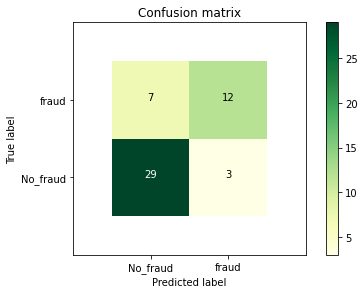

In [573]:
# example of confusion matrix  
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 
from sklearn.ensemble import BaggingClassifier

dte_ = DecisionTreeClassifier(max_depth= 600, min_samples_split= 2,class_weight = {0: 1, 1: 1} )
dte_.fit(X_train, y_train)
tree_pred = dte_.predict(X_test)
tree_pro = dte_.predict_proba(X_test)
scors_aff(y_test , tree_pred)

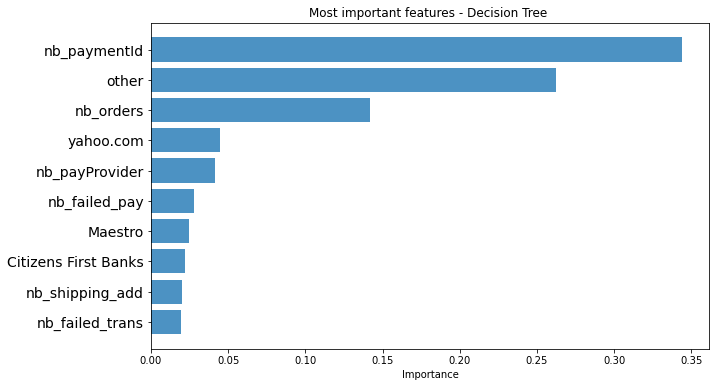

In [555]:
# get features importances through decision tree
feature_names = X_train.columns
feature_imports = dte_.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree ')
plt.show()


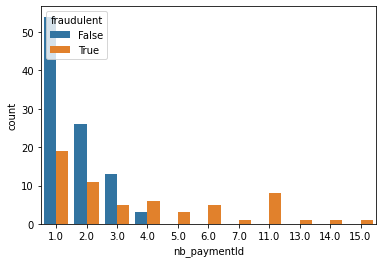

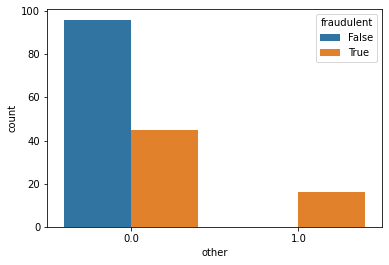

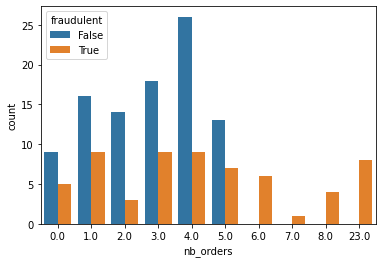

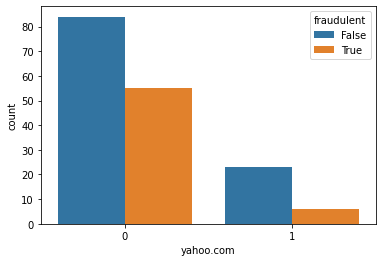

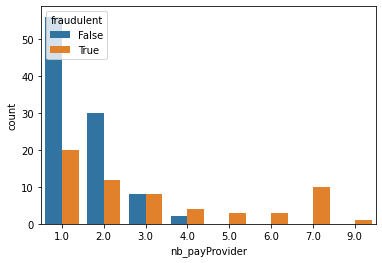

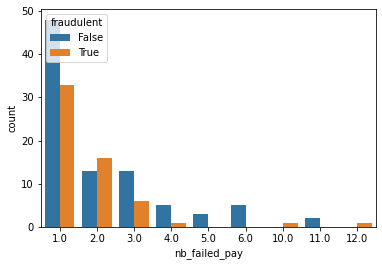

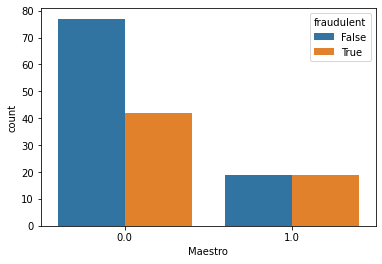

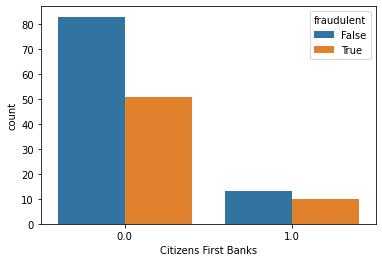

In [570]:
### see the effect of the imortante features
for i, col in enumerate(most_imp_features.nlargest(10,'Importance').Feature[:8]):
    plt.figure(i)
    sns.countplot(x=col,hue = 'fraudulent',data=df)